# Preliminary analysis

In [1]:
seed = 0

In [2]:
from utilities.load_data import load_fullECAI
from utilities.evaluation import *

In [16]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier, Booster, DMatrix

# define models to test
def get_models():
    models, names = list(), list()
    # LR
    models.append(LogisticRegression(solver='liblinear'))
    names.append('LR')
    # LDA
    models.append(LinearDiscriminantAnalysis())
    names.append('LDA')
    # NB
    models.append(GaussianNB())
    names.append('NB')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    # XGB
    models.append(XGBClassifier(use_label_encoder=False))
    names.append('XGB')
    return models, names

No se muestran pero las variable de constraints (eliminadas por los autores originales) presentan un alta correlación con el status

In [5]:
dataset = load_fullECAI()
# Prep data
X = dataset.drop('status', axis=1)
y = dataset.loc[:, 'status']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=seed, stratify=y)

## Baseline

### Dummy Classifier

In [6]:
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X_train, y_train, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean F2: 0.378 (0.000)


### Logistic Regression

In [42]:
%%time
model = LogisticRegression(max_iter=1000)
norm = Normalizer()
model = Pipeline([('nr', norm),('lr', model)])
scores = evaluate_model(X_train, y_train, model, balanced_accuracy_score)
print('min:', np.min(scores))
print('max:', np.max(scores))
print('mean:', np.mean(scores))

min: 0.5122967795381589
max: 0.5295381588485037
mean: 0.520097394051066
Wall time: 2.33 s


In [43]:
model.fit(X_train, y_train)

Pipeline(steps=[('nr', Normalizer()),
                ('lr', LogisticRegression(max_iter=1000))])

In [44]:
balanced_accuracy_score(y_test, model.predict(X_test))

0.5242100340933256

## Modeling

### XGboost

In [10]:
%%time
model = XGBClassifier(use_label_encoder=False, max_depht=10)
scores = evaluate_model(X_train, y_train, model, roc_auc_score, splits=5, reps=3, seed=seed)



min: 0.6584190620791213
max: 0.7020086708176224
mean: 0.6803588081810469
Wall time: 5.73 s


In [11]:
model.fit(X_train, y_train)

[14:35:35] WARNING: ..\src\learner.cc:576: 
Parameters: { "max_depht" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:35:35] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depht=10, max_depth=6, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=12, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

## Shap Values

In [13]:
import shap

%%time
explainer = shap.Explainer(model.named_steps['lr'], model.named_steps['nr'].transform(X_train))
shap_test = explainer(model.named_steps['nr'].transform(X_train))
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_train.index)
shap_df

%%time
explainer = shap.Explainer(model.named_steps['lr'], model.named_steps['nr'].transform(X_train))
shap_test = explainer(model.named_steps['nr'].transform(X_train))
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_train.index)
shap_df

In [15]:
explainer = shap.Explainer(model)
shap_test = explainer(X_test)
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9,V_10,V_11,V_12,V_13,V_14,V_15,V_20,V_21,V_22,V_23
1432,-0.022977,0.026270,-0.214491,0.490359,-0.205762,-0.318533,-0.086688,-0.147337,-0.004353,0.139069,-0.023290,-0.351321,-0.255691,-0.106669,0.022602,-0.046319,1.215681,0.552688,-0.191477
6854,0.323163,-0.406239,0.265803,0.644376,0.414649,-0.046801,-0.152639,-0.244620,-0.132975,0.000147,-0.028581,-0.807198,-0.407615,-0.115561,-0.011633,-0.006693,0.669096,-0.329890,0.076355
9463,-0.249827,-0.038092,-0.757189,0.416976,-0.072741,-0.620153,0.009012,-0.154149,-0.097912,-0.266937,-0.193750,-0.223984,1.080504,-0.137205,-0.021213,-0.080873,0.859391,0.121607,-0.205109
8404,0.049650,0.172642,-0.273419,-0.163580,0.188585,-0.214619,0.245930,-0.135450,0.091980,0.583606,0.717834,-0.316967,-0.584991,-0.158475,0.054249,0.121730,-0.371612,-0.307562,-0.201397
7410,0.276195,0.085940,-0.180072,-0.278524,-0.036670,0.041958,-0.193025,-0.277758,0.000861,-0.099991,-0.082280,-0.142125,-0.326814,-0.070431,-0.008275,-0.034324,-0.208963,0.079464,-0.149354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,-0.266826,-0.009624,-0.054766,0.051528,-0.192757,-0.368635,0.087114,0.274277,-0.410506,-0.018221,-0.179625,-0.064873,-0.826546,0.159324,-0.034670,-0.216779,-0.044187,-0.011668,-0.506819
13040,-0.315536,0.032491,-0.447777,-0.358117,0.219373,0.074930,-0.504177,0.485265,-0.439093,-0.130503,0.000302,-0.016242,-1.297936,0.391914,-0.133639,-0.106834,-0.132896,-0.101853,0.618334
5466,-0.098131,0.101070,-0.317731,-1.075204,0.266271,0.359704,-0.045767,-0.467512,0.300339,-0.192063,-0.045792,0.098511,1.101530,0.349214,0.016300,-0.102031,0.018419,-0.211447,0.514293
6397,0.311140,-0.356021,0.039956,-0.054540,-0.077514,0.062434,-0.033533,-0.213080,-0.088199,0.228424,-0.081921,-0.112179,0.222202,0.205331,-0.017211,-0.247702,-0.279218,-0.612643,0.157994


In [17]:
shap_df.iloc[1432]

V_1     0.125160
V_2    -0.173214
V_3     0.051100
V_4     0.143389
V_5    -0.080179
V_6     0.313055
V_7     0.084823
V_8    -0.196421
V_9    -0.046559
V_10   -0.039472
V_11   -0.090103
V_12   -0.257617
V_13   -1.046585
V_14   -0.248203
V_15   -0.092154
V_20   -0.186366
V_21    0.685786
V_22   -0.337613
V_23    0.000621
Name: 13784, dtype: float32

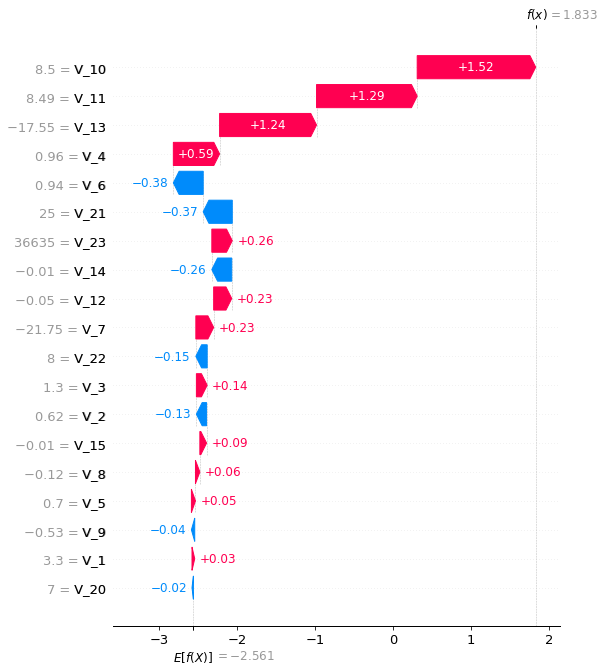

In [37]:
shap.plots.waterfall(shap_test[0], max_display=19)

Los más importantes son  Operating revenues/Total assets,  Sales/Total assets,  EBITDA/interest paid

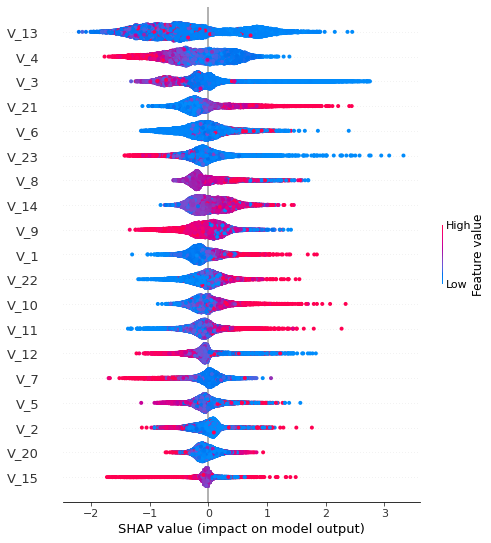

In [41]:
shap.plots.beeswarm(shap_test, max_display=19)

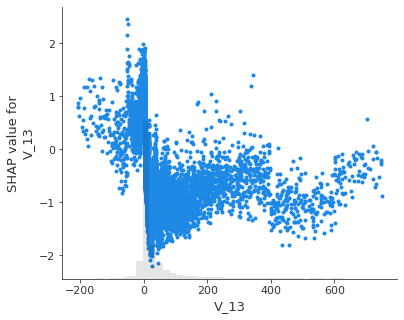

In [48]:
shap.plots.scatter(shap_test[:,12])

V13- EBITDA/Interest paid. Si el valor es negativo la probabilidad de impago crece mucho, esto implica perdidas en la empresa

## Graph representation

In [80]:
from igraph import Graph
import igraph as ig
from sklearn.metrics import euclidean_distances
import matplotlib.pyplot as plt

In [138]:
%%time
shap_dist = euclidean_distances(shap_df)

fullg = Graph.Weighted_Adjacency(shap_dist, mode='undirected')
mst = fullg.spanning_tree(fullg.es['weight'])
colors = np.array(['#808080']*y_train.shape[0])
colors[y_train == 1] = '#FF0000'
mst.vs['color'] = colors.tolist()

Wall time: 2min


In [ ]:
#mst.layout_davidson_harel()

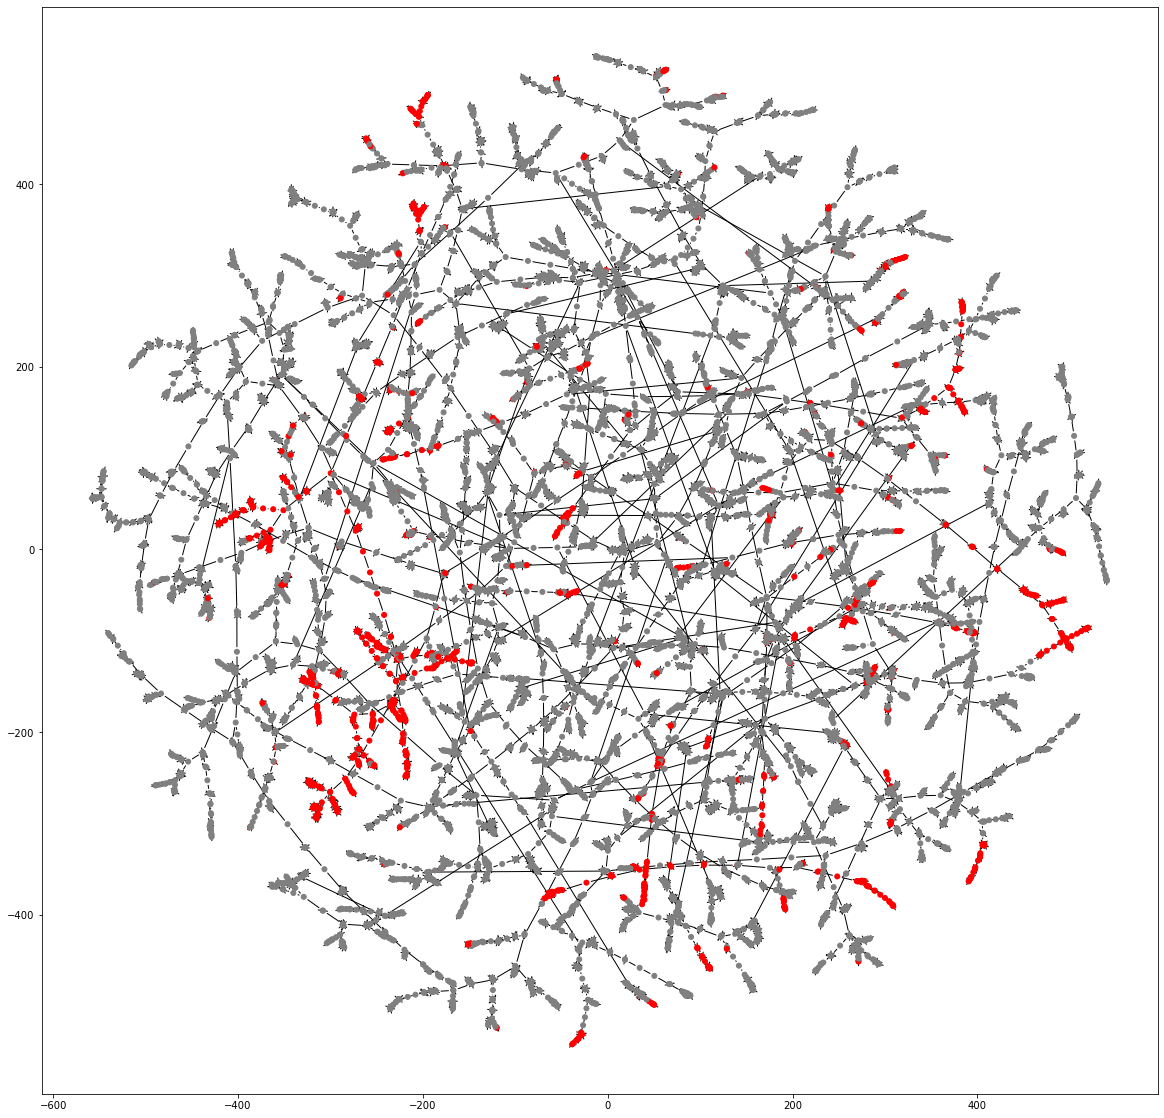

In [139]:
fig, ax = plt.subplots(figsize=(20, 20))
ig.plot(mst, target=ax, vertex_color = mst.vs['color'])

## Alternative models

In [57]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import InstanceHardnessThreshold

In [58]:
def get_models():
    models, names = list(), list()
    # TL
    models.append(TomekLinks())
    names.append('TL')
    # ENN
    models.append(EditedNearestNeighbours())
    names.append('ENN')
    # RENN
    models.append(RepeatedEditedNearestNeighbours())
    names.append('RENN')
    # OSS
    models.append(OneSidedSelection())
    names.append('OSS')
    # NCR
    models.append(NeighbourhoodCleaningRule())
    names.append('NCR')
    # IHT
    models.append(InstanceHardnessThreshold())
    names.append('IHT')
    return models, names

In [59]:
# define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
    # define model to evaluate
    model = LogisticRegression(solver='liblinear', class_weight='balanced')
    # scale, then undersample, then fit model
    pipeline = Pipeline(steps=[('nr',norm), ('s', models[i]), ('m',model)])
    # evaluate the model and store results
    pipeline.fit(X_train, y_train)
    print(balanced_accuracy_score(y_test, model.predict(X_test)))

X has feature names, but LogisticRegression was fitted without feature names


0.6675123305337629


X has feature names, but LogisticRegression was fitted without feature names


0.631065513606461


X has feature names, but LogisticRegression was fitted without feature names


0.6259760957997298


X has feature names, but LogisticRegression was fitted without feature names


0.6729447395439132


X has feature names, but LogisticRegression was fitted without feature names


0.6384752669043214
0.5912608127976878


X has feature names, but LogisticRegression was fitted without feature names


In [62]:
pipeline.predict(X)

array([0, 0, 0, ..., 0, 1, 1], dtype=int64)

In [74]:
def example(X):
    return np.array([[1,0]]*X.shape[0])

In [75]:
example(X)

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

%%time
explainer = shap.Explainer(model.named_steps['lr'], model.named_steps['nr'].transform(X_train))
shap_test = explainer(model.named_steps['nr'].transform(X_train))
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_train.index)
shap_df

In [111]:
pipeline.named_steps

{'nr': Normalizer(),
 's': InstanceHardnessThreshold(),
 'm': LogisticRegression(class_weight='balanced', solver='liblinear')}

In [158]:
explainer = shap.LinearExplainer(pipeline.named_steps['m'], pipeline.named_steps['s'].fit_resample(pipeline.named_steps['nr'].transform(X_train), y_train)[0])
shap_test = explainer(pipeline.named_steps['nr'].transform(X_test))
shap_df = pd.DataFrame(shap_test.values, 
                       columns=shap_test.feature_names, 
                       index=X_test.index)
shap_df

Exception: An unknown model type was passed: <class 'method'>

In [141]:
pipeline.predict_log_proba(X_test.iloc[3:4])

array([[-0.42241721, -1.06554659]])

In [135]:
pipeline.predict_proba(X_test.iloc[2:3])

array([[0.05324522, 0.94675478]])

In [143]:
np.exp(-0.643)

0.5257129172157903

In [171]:
pipeline.named_steps['m'].predict(pipeline.named_steps['nr'].transform(X_test.iloc[3:4]))

array([0], dtype=int64)

In [155]:
pipeline.named_steps['nr'].transform(X_test.iloc[0:1])

array([[1.21089610e-02, 0.00000000e+00, 1.97768130e-03, 1.71746008e-03,
        1.56132735e-03, 1.64806775e-03, 4.09414726e-03, 5.20442448e-05,
        2.60221224e-04, 1.26640996e-03, 1.26640996e-03, 7.28619428e-04,
        1.39825538e-02, 2.60221224e-04, 2.60221224e-04, 6.24530938e-02,
        5.60343036e-01, 7.02597305e-01, 4.33702040e-01]])

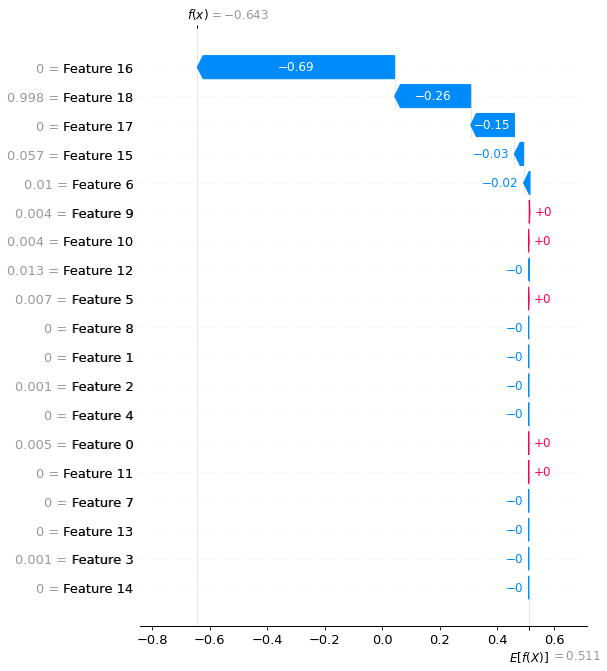

In [163]:
shap.plots.waterfall(shap_test[3], max_display=19)

Ya que se utiliza un modelo logístico, se muestran log-odds

In [117]:
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import InstanceHardnessThreshold

In [120]:
model = LogisticRegression(solver='liblinear', class_weight='balanced')
# define the data sampling
sampling = InstanceHardnessThreshold()
# scale, then sample, then fit model
model = Pipeline(steps=[('nr',norm), ('s', sampling), ('m',model)])

In [121]:
model.fit(X_train, y_train)
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80      2683
           1       0.20      0.62      0.30       326

    accuracy                           0.69      3009
   macro avg       0.57      0.66      0.55      3009
weighted avg       0.86      0.69      0.75      3009

